# 十月武汉新房房价分析及可视化
#### 数据来源：贝壳找房
#### 更新时间: 2020.10.02
- 采用[@jumper2014](https://github.com/jumper2014)编写的找房[爬虫](https://github.com/jumper2014/lianjia-beike-spider)获取
- 添加了区域信息，户型、面积信息

In [102]:
import numpy as np
import pandas as pd

### 读取武汉房源数据，为CSV格式

In [109]:
file = '../data/new/wh.csv'
df = pd.read_csv(file,parse_dates=True)
df['日期'] = pd.to_datetime(df['日期'],format="%Y%m%d")
df.head()


,日期,楼盘,单价,底价,地区,户型,面积
0,2020-10-02,首开&华侨城&金茂|东湖金茂府,26500,300万,洪山/青山,3/4,118-141
1,2020-10-02,长江凯旋城,11300,122万,黄陂/武湖,3,108-124
2,2020-10-02,美好长江首玺,13500,125万,洪山/白沙洲,3,97-123
3,2020-10-02,海伦堡汉江府,8200,79万,东西湖/东西湖其它,3/4,96-130
4,2020-10-02,兰亭大境,16250,171万,沌口开发区/沌口,3/4,105-143


### 数据清洗操作，包括：
- 格式转换
- 去除空值、异常值
- 将各楼盘位置划分到对应行政区
- 各楼盘最大/最小面积

In [110]:
df['单价'] = df['单价'].replace('价格待定',None).astype(float)
df.dropna(inplace=True)

df['底价'] = df['底价'].str.strip('万')
df['底价'] = df['底价'].astype(float)

# 将地区转为具体行政区和商圈
df['行政区'] = [i.split('/')[0] for i in df['地区']]
df['商圈'] = [i.split('/')[1] for i in df['地区']]

#将面积转为最大面积和最小面积
area = [i.split('-') for i in df['面积']]
df['最小面积'] = [i[0] for i in area]
df['最大面积'] = [i[1] if len(i)==2 else i[0] for i in area ]
df['最小面积'] = df['最小面积'].astype(int)
df['最大面积'] = df['最大面积'].astype(int)
# df['最小户型'] = df['户型'].str.split('/')[0]
# df['最大户型'] = df['户型'].str.split('/')[-1]
df['最小户型'] = [0]*len(df)
df['最大户型'] = [0]*len(df)
for i in range(len(df)):
    tmp = df['户型'][i].split('/')
    try:
        df['最小户型'][i] = tmp[0]
        df['最大户型'][i] = tmp[-1]
    except:
        df['最小户型'][i] = None
        df['最大户型'][i] = None
        
df['最小户型'] = df['最小户型'].astype(int)
df['最大户型'] = df['最大户型'].astype(int)

/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [111]:
df_p = df[df['单价']>3000]
df_p = df_p.drop(['地区','面积'],axis=1)
print(df_p.shape)
df_p.head()

(984, 11)


,日期,楼盘,单价,底价,户型,行政区,商圈,最小面积,最大面积,最小户型,最大户型
0,2020-10-02,首开&华侨城&金茂|东湖金茂府,26500.0,300.0,3/4,洪山,青山,118,141,3,4
1,2020-10-02,长江凯旋城,11300.0,122.0,3,黄陂,武湖,108,124,3,3
2,2020-10-02,美好长江首玺,13500.0,125.0,3,洪山,白沙洲,97,123,3,3
3,2020-10-02,海伦堡汉江府,8200.0,79.0,3/4,东西湖,东西湖其它,96,130,3,4
4,2020-10-02,兰亭大境,16250.0,171.0,3/4,沌口开发区,沌口,105,143,3,4


In [112]:
print('房屋单价分布情况')
df_p[['单价']].describe()

房屋单价分布情况


,单价
count,984.000000
mean,19998.128923
std,10733.794304
min,5300.000000
25%,12000.000000
50%,16980.000000
75%,26000.000000
max,70000.000000


- 由上表可知，经过去除异常值后，房屋单价均值约为20000，最小值为5300，最大值为70000，中位数为17000，比较符合市场行情，因此可以肯定数据集的真实性。

In [113]:
df_a = df[df['最小面积']>0]
df_a = df_a[df_a['最小户型']>0]
df_a = df_a[df_a['单价']>3000]
df_a = df_a.drop(['底价','地区','面积'],axis=1)
print(df_a.shape)
print('房屋面积分布情况')
df_a[['最小面积','最大面积']].describe()

(627, 10)
房屋面积分布情况


,最小面积,最大面积
count,627.000000,627.000000
mean,106.569378,150.631579
std,69.991028,97.291334
min,15.000000,23.000000
25%,80.000000,117.000000
50%,98.000000,135.000000
75%,117.500000,165.000000
max,1119.000000,1206.000000


### 作图分析

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')
# 解决中文字体乱码的问题
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [115]:
color = ['#FFB6C1','#DA70D6','#7B68EE','#4169E1','#ADD8E6','#7FFFAA',
             '#808000','#FFE4B5','#FFFF00','#FF0000','#DCDCDC','#EEE0E5',
             '#DC143C','#D8BFD8','#9B30FF','#0000FF','#00BFFF','#7FFFAA',
             '#2E8B57','#FAFAD2','#FFFF00','#FF8C00','#800000','#FF69B4',
             '#BA55D3','#483D8B','#191970','#AFEEEE','#40E0D0','#D2691E']


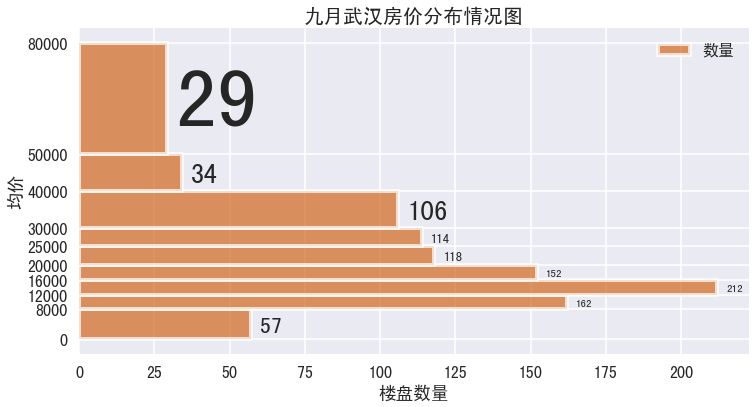

In [116]:
# 房屋单价分布情况
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)

b_ins = list(range(0,72001,4000))
b_ins = [0,8000,12000,16000,20000,25000,30000,40000,50000,80000]


n, bins, patches = ax1.hist(df_p['单价'],bins=b_ins, histtype='bar',
                            facecolor='chocolate', edgecolor='white', linewidth=4,alpha=0.7,
                            orientation='horizontal',label='数量')
ax1.set_yticks(bins)
ax1.set_xlabel(u'楼盘数量')
ax1.set_ylabel(u'均价')
ax1.legend(loc=1)
ax1.set_title(u'九月武汉房价分布情况图',fontsize=20)
y = []
for i in range(len(bins)-1):
    y.append((bins[i]+bins[i+1])/2)
    plt.text(n[i]+3,y[i]-(bins[i+1]-bins[i])//4,u'{}'.format(int(n[i])),fontsize=(bins[i+1]-bins[i])//360)
plt.show()

 - 上图房屋单价的频率分布直方图，可以看到，大部分房价在8000到40000之间，峰值位于12000-16000。

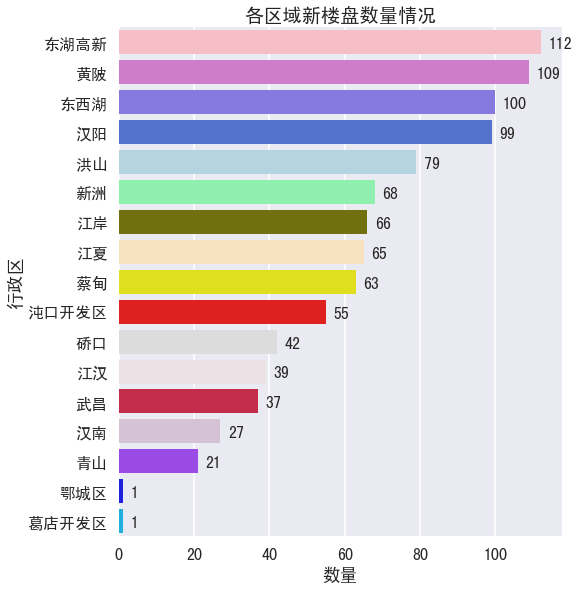

<Figure size 921.6x633.6 with 0 Axes>

In [117]:
tmp = pd.DataFrame(df_p['行政区'].value_counts()).reset_index().rename(columns={'index':'行政区','行政区':'数量'})
sns.catplot(x ='数量',y ='行政区',data=tmp,kind='bar',palette=color[:len(tmp)],height=8)
plt.title('各区域新楼盘数量情况')
for i in range(len(tmp)):
    plt.text(x=tmp['数量'][i]+2,y=i+0.2,s=tmp['数量'][i],fontsize=16)
plt.show()
plt.clf()

- 楼盘数量最多的为东湖高新区和黄陂区，均超过了110家；最少的为华容区，仅一家。
- 新房数量较多的区域多为新城区。

<Figure size 1440x720 with 0 Axes>

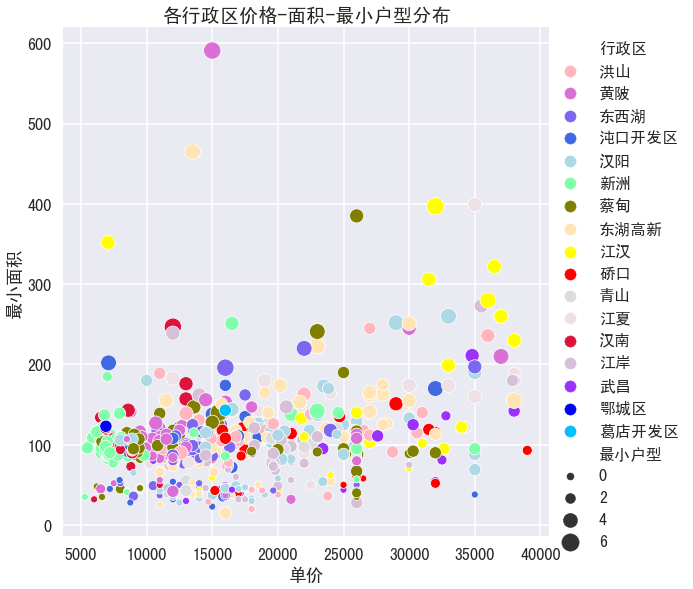

<Figure size 921.6x633.6 with 0 Axes>

In [118]:
# 房屋最低单价与最小面积之间的关系
# sns.distplot(df['单价'], kde=True, bins=20, rug=False,kde_kws={})
df_t = df_a[df_a['单价']<40000]
plt.figure(figsize=(20, 10))
sns.relplot(x = '单价', y ='最小面积',hue='行政区',size='最小户型',
            sizes = (50,300), alpha=1, palette=color[:17],
            data=df_t,kind='scatter', height=8)

plt.title("各行政区价格-面积-最小户型分布")
plt.show()
plt.clf()

#### 仅考虑每平米单价40000以下，面积400平米以下的住宅：
- 总体上来说，呈现最小面积越大，单价越高的趋势。
- 黄陂区、东湖高新区各有一处单价较低但面积十分大的楼盘
- 粗略来看，江汉区房子更大，江岸区房子更贵。新洲、汉南房子最便宜。

/Users/frank-lsy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


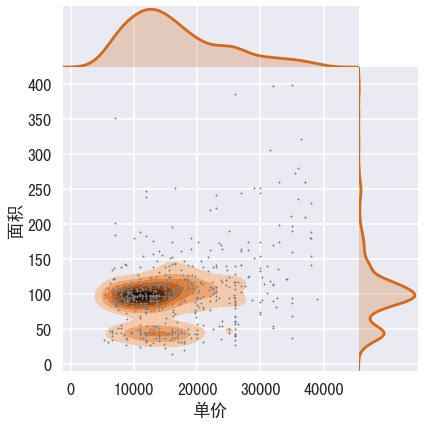

<Figure size 921.6x633.6 with 0 Axes>

In [119]:
df_t = df_t[df_t['最小面积']<400]
g = sns.jointplot(x="单价", y="最小面积", data=df_t, kind="kde", color="chocolate",space=0)
g.plot_joint(plt.scatter, c="gray", s=3, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("单价", "面积");
plt.show()
plt.clf()

#### 由以上联合分布图可以看出:
- 有两块密集分布区:单价均为10000-15000，面积为50和100
- 结合房价-面积-最小户型分布图：
    - 50平米左右楼盘最小户型为1
    - 100平米左右楼盘最小户型为2-3
    - 因此，可推测50平米可能多为loft公寓(40年产权),100平米为正常商品房住宅(70年产权)

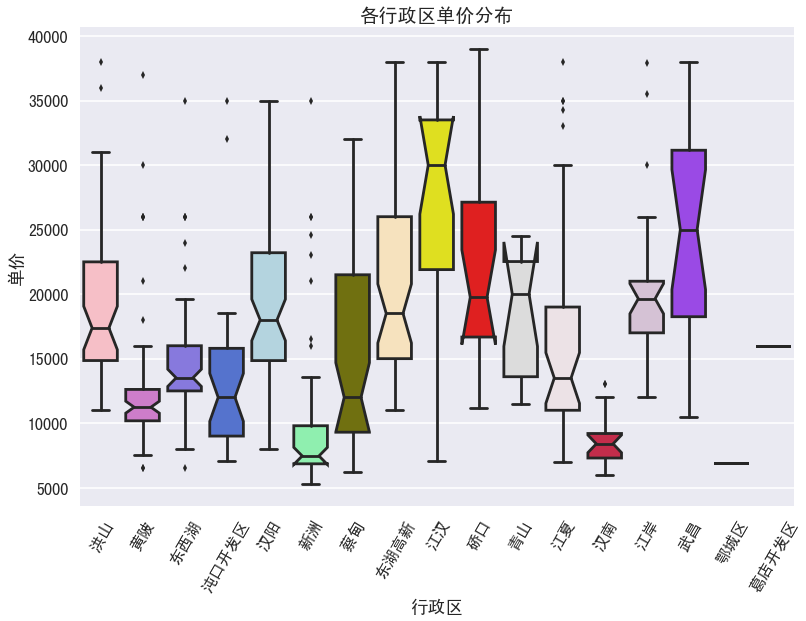

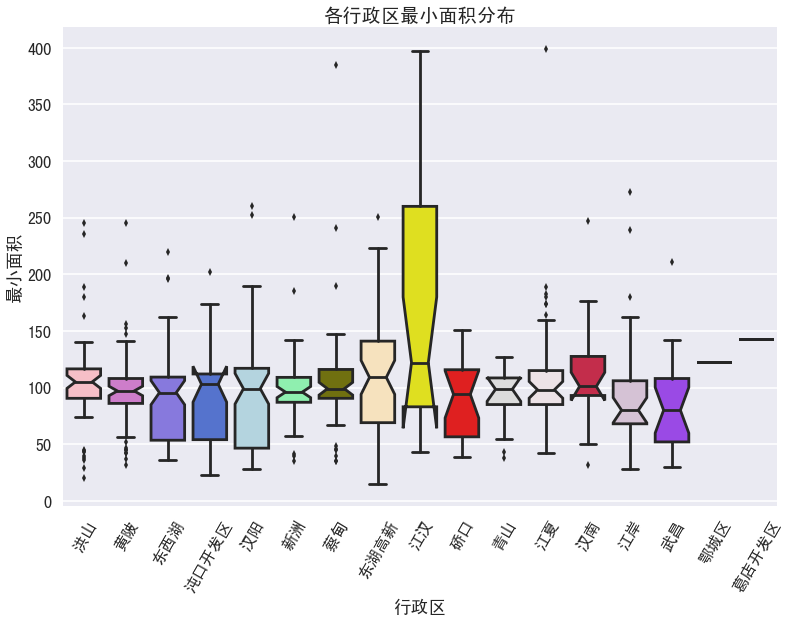

<Figure size 921.6x633.6 with 0 Axes>

In [120]:
# 箱线图+虫图，具体分析各区房价、房屋面积分布情况
sns.boxplot(x='行政区',y='单价',data=df_t,palette=color[:16],notch=True)
# sns.swarmplot(x='行政区',y='单价',data=df_a,color='#000000',alpha=0.8,size=2)
plt.xticks(rotation=60)
plt.title('各行政区单价分布')
plt.show()
plt.clf()
sns.boxplot(x='行政区',y='最小面积',data=df_t,palette=color[:16],notch=True)
# sns.swarmplot(x='行政区',y='最小面积',data=df_a,color='black',alpha=0.8,size=2)
plt.xticks(rotation=60)
plt.title('各行政区最小面积分布')
plt.show()
plt.clf()

- 单价来看，最低的为汉南、新洲，单价还没有达到10000；最高为江汉、武昌区，均超过了20000；
- 从房屋面积来看，除江汉区外，总体无较大差异。
- 江汉区房价高、房屋面积大，可能多为高端住宅区
- 武昌区房价高、房屋面积大，可能多为loft公寓
- 东湖高新区、硚口区、青山区处在均价15000-20000，房屋面积100平米左右；黄陂区、蔡甸区、青山区均价在10000-15000，房屋面积100平米左右，且楼盘数量较大，可能存在集中开发的中档住宅区，但由于地域原因，房价有约每平米5000的差距，推测这些地区可能为未来武汉住宅区的发展方向。

#### 下一步任务
- **结合武汉地图进行进一步分析**
- **进一步拆分热门行政区(黄陂、蔡甸、东湖高新、汉阳、武昌、江汉)，分析各商业圈的楼盘情况**